In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

In [31]:
# Parameters
num_homes = 5
tank_capacity = 1000  # Each home's tank capacity in liters
daily_water_supply = 2500  # Daily water supply in liters

# Generate sample data for 7 days (1 week)
days = pd.date_range(start="2024-08-01", end="2024-08-07", freq="D")

# Simulate electricity consumption (kWh) for each home
data = {
    "Day": np.repeat(days, num_homes),
    "HomeID": np.tile(range(1, num_homes + 1), len(days)),
    "ElectricityUsage(kWh)": np.random.uniform(10, 50, size=len(days) * num_homes),
}

df = pd.DataFrame(data)
df

,Day,HomeID,ElectricityUsage(kWh)
0,2024-08-01,1,13.133437
1,2024-08-01,2,22.712531
2,2024-08-01,3,43.529048
3,2024-08-01,4,12.966693
4,2024-08-01,5,15.643669
5,2024-08-02,1,32.027657
6,2024-08-02,2,45.821868
7,2024-08-02,3,29.769745
8,2024-08-02,4,48.454057
9,2024-08-02,5,20.671276


In [32]:
# Function to simulate sensor readings for water level
def simulate_sensor_readings(num_homes, tank_capacity):
    return np.random.randint(0, tank_capacity, size=num_homes)

# Initialize water levels based on simulated sensor readings
initial_water_level = simulate_sensor_readings(num_homes, tank_capacity)
df["CurrentWaterLevel(L)"] = np.tile(initial_water_level, len(days))
df

,Day,HomeID,ElectricityUsage(kWh),CurrentWaterLevel(L)
0,2024-08-01,1,13.133437,327
1,2024-08-01,2,22.712531,278
2,2024-08-01,3,43.529048,615
3,2024-08-01,4,12.966693,833
4,2024-08-01,5,15.643669,406
5,2024-08-02,1,32.027657,327
6,2024-08-02,2,45.821868,278
7,2024-08-02,3,29.769745,615
8,2024-08-02,4,48.454057,833
9,2024-08-02,5,20.671276,406


In [19]:
# Function to calculate water needed for each home
def calculate_water_needed(df, tank_capacity):
    df["WaterNeeded(L)"] = tank_capacity - df["CurrentWaterLevel(L)"]
    df["WaterNeeded(L)"] = df["WaterNeeded(L)"].clip(lower=0)  # Ensure no negative values
    return df

In [34]:
# Revised Round-Robin Water Allocation Algorithm with Sensor Integration
def round_robin_allocation(df, daily_water_supply, simulate_sensor_readings):
    homes = df["HomeID"].unique()
    
    # Initialize PumpedWater column
    df["PumpedWater(L)"] = 0
    
    for day in df["Day"].unique():
        available_water = daily_water_supply
        
        # Update water levels based on sensor readings for the current day
        current_sensor_readings = simulate_sensor_readings(len(homes), tank_capacity)
        df.loc[df["Day"] == day, "CurrentWaterLevel(L)"] = current_sensor_readings
        
        # Calculate water needed based on updated sensor readings
        df = calculate_water_needed(df, tank_capacity)
        
        while available_water > 0:
            for home in homes:
                home_water_needed = df.loc[(df["Day"] == day) & (df["HomeID"] == home), "WaterNeeded(L)"].values[0]
                allocation = min(available_water, home_water_needed)
                df.loc[(df["Day"] == day) & (df["HomeID"] == home), "PumpedWater(L)"] = allocation
                available_water -= allocation
                if available_water <= 0:
                    break
            
            # Update current water level after allocation
            df.loc[df["Day"] == day, "CurrentWaterLevel(L)"] += df.loc[df["Day"] == day, "PumpedWater(L)"].astype(np.int32)
    
    return df

In [35]:
# Apply round-robin allocation
df_allocated = round_robin_allocation(df, daily_water_supply, simulate_sensor_readings)
df_allocated

,Day,HomeID,ElectricityUsage(kWh),CurrentWaterLevel(L),PumpedWater(L),WaterNeeded(L)
0,2024-08-01,1,13.133437,1000,406,0
1,2024-08-01,2,22.712531,1000,997,0
2,2024-08-01,3,43.529048,1000,838,0
3,2024-08-01,4,12.966693,1000,110,0
4,2024-08-01,5,15.643669,998,149,2
5,2024-08-02,1,32.027657,1000,809,0
6,2024-08-02,2,45.821868,1000,962,0
7,2024-08-02,3,29.769745,1000,557,0
8,2024-08-02,4,48.454057,515,172,485
9,2024-08-02,5,20.671276,605,0,395


In [36]:
# Energy Efficiency Optimization Algorithm
def energy_efficiency_optimization(df):
    # Scale electricity usage to identify peaks
    scaler = MinMaxScaler()
    df["ScaledElectricityUsage"] = scaler.fit_transform(df[["ElectricityUsage(kWh)"]])
    
    # Identify peak usage periods (scaled value > 0.8)
    df["PeakUsage"] = df["ScaledElectricityUsage"] > 0.8
    
    # Shift peak loads to off-peak periods by reducing usage by 20% during peaks
    df["OptimizedElectricityUsage(kWh)"] = df["ElectricityUsage(kWh)"]
    df.loc[df["PeakUsage"], "OptimizedElectricityUsage(kWh)"] = df["ElectricityUsage(kWh)"] * 0.8
    
    return df

In [38]:
# Apply energy efficiency optimization
df_optimized = energy_efficiency_optimization(df_allocated)
df_optimized

,Day,HomeID,ElectricityUsage(kWh),CurrentWaterLevel(L),PumpedWater(L),WaterNeeded(L),ScaledElectricityUsage,PeakUsage,OptimizedElectricityUsage(kWh)
0,2024-08-01,1,13.133437,1000,406,0,0.059749,False,13.133437
1,2024-08-01,2,22.712531,1000,997,0,0.314749,False,22.712531
2,2024-08-01,3,43.529048,1000,838,0,0.868894,True,34.823238
3,2024-08-01,4,12.966693,1000,110,0,0.055310,False,12.966693
4,2024-08-01,5,15.643669,998,149,2,0.126573,False,15.643669
5,2024-08-02,1,32.027657,1000,809,0,0.562722,False,32.027657
6,2024-08-02,2,45.821868,1000,962,0,0.929930,True,36.657494
7,2024-08-02,3,29.769745,1000,557,0,0.502615,False,29.769745
8,2024-08-02,4,48.454057,515,172,485,1.000000,True,38.763246
9,2024-08-02,5,20.671276,605,0,395,0.260410,False,20.671276


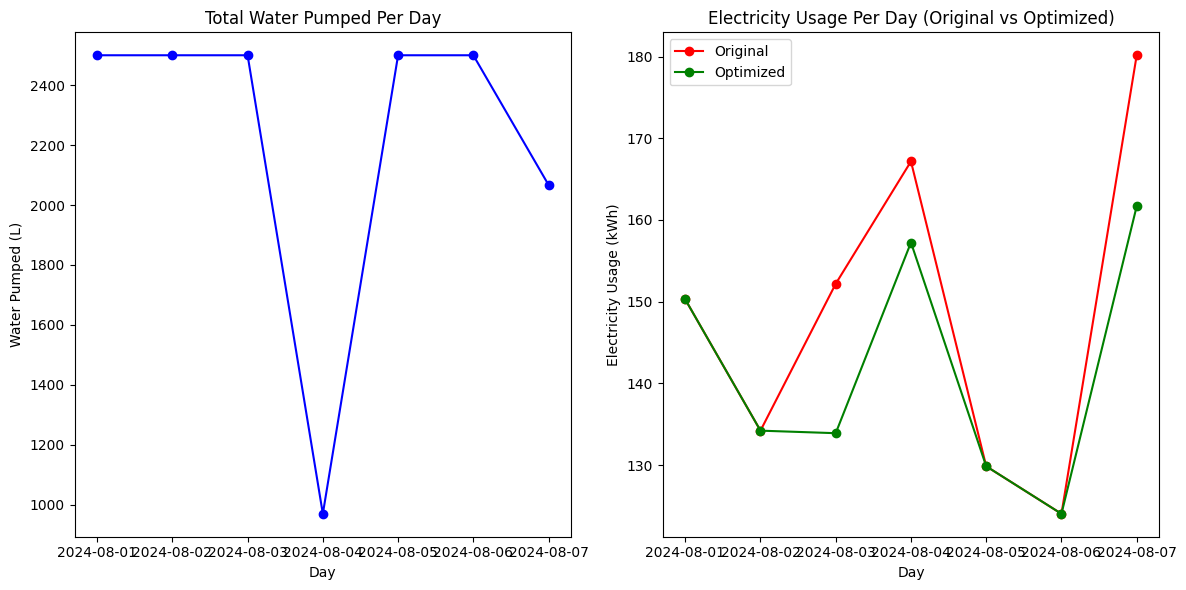

In [24]:
# Summary and Visualization
# Summarize water pumping and electricity usage
allocation_summary = df_optimized.groupby("Day").agg(
    {"PumpedWater(L)": "sum", "ElectricityUsage(kWh)": "sum", "OptimizedElectricityUsage(kWh)": "sum"}
)

# Plot the results
plt.figure(figsize=(12, 6))

# Water Pumping
plt.subplot(1, 2, 1)
plt.plot(allocation_summary.index, allocation_summary["PumpedWater(L)"]
         , marker='o', color='blue')
plt.title('Total Water Pumped Per Day')
plt.xlabel('Day')
plt.ylabel('Water Pumped (L)')

# Electricity Usage
plt.subplot(1, 2, 2)
plt.plot(allocation_summary.index, allocation_summary["ElectricityUsage(kWh)"]
         , marker='o', label='Original', color='red')
plt.plot(allocation_summary.index, allocation_summary["OptimizedElectricityUsage(kWh)"]
         , marker='o', label='Optimized', color='green')
plt.title('Electricity Usage Per Day (Original vs Optimized)')
plt.xlabel('Day')
plt.ylabel('Electricity Usage (kWh)')
plt.legend()

plt.tight_layout()
plt.show()

In [25]:
# Sample data preparation for modeling
# Converting 'Day' to ordinal values for easier modeling
df['Day'] = pd.to_datetime(df['Day']).map(lambda date: date.toordinal())

In [26]:
# Handle Missing Values
# Check for NaNs in target variable
print("NaNs in target variable:", df['PumpedWater(L)'].isna().sum())

# Remove rows with NaNs in target variable
df_cleaned = df.dropna(subset=['PumpedWater(L)'])

# Re-define features and target
features = ['Day', 'ElectricityUsage(kWh)']
target = 'PumpedWater(L)'

X = df_cleaned[features]
y = df_cleaned[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Impute NaNs if necessary (for general robustness)
imputer = SimpleImputer(strategy='mean')
y_train = imputer.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test = imputer.transform(y_test.values.reshape(-1, 1)).ravel()

NaNs in target variable: 0


In [27]:
# Train Stacking Model
# Stacking model setup
base_models = [
    ('gb', GradientBoostingRegressor(n_estimators=100, random_state=42)),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42))
]
meta_model = Ridge()

stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model)

# Training the model
stacking_model.fit(X_train, y_train)

# Predicting on the test set
y_pred = stacking_model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 331.9222009188838


In [28]:
# Predict Future Water Usage
# Future prediction
future_days = pd.date_range(start="2024-08-08", end="2024-08-14", freq="D")
future_data = pd.DataFrame({
    'Day': future_days.map(lambda date: date.toordinal()),
    'ElectricityUsage(kWh)': np.random.uniform(10, 50, len(future_days))  # Replace with more accurate estimates if available
})

future_predictions = stacking_model.predict(future_data)
future_data['PredictedWaterUsage(L)'] = future_predictions

# Display predictions
print(future_data)

      Day  ElectricityUsage(kWh)  PredictedWaterUsage(L)
0  739106              41.834402              499.006018
1  739107              26.346256              361.040688
2  739108              19.675997              564.314419
3  739109              39.038075              423.656873
4  739110              22.811740              494.792740
5  739111              35.251611              508.389540
6  739112              10.203244              431.075851


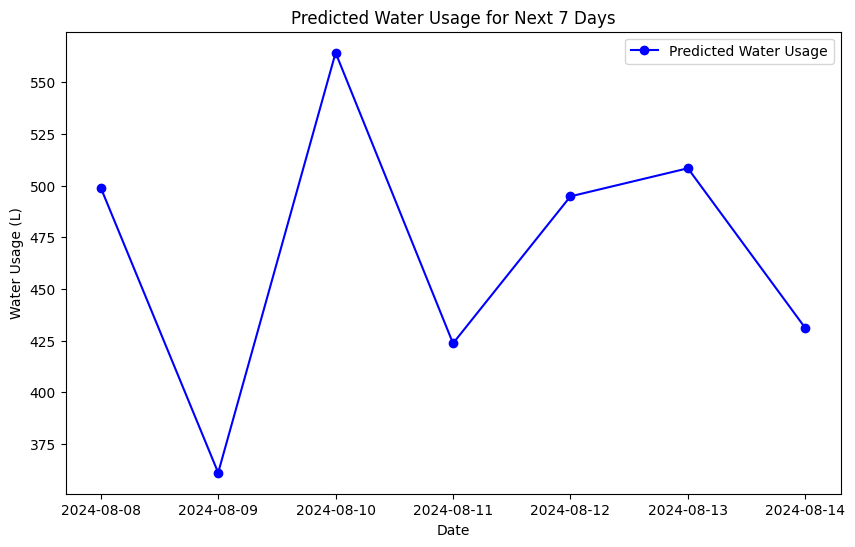

In [29]:
# Visualization of future predictions
plt.figure(figsize=(10, 6))
plt.plot(future_days, future_predictions, marker='o', color='blue', label='Predicted Water Usage')
plt.title('Predicted Water Usage for Next 7 Days')
plt.xlabel('Date')
plt.ylabel('Water Usage (L)')
plt.legend()
plt.show()

In [30]:
# Define and Apply Round-Robin Allocation
# Round-robin allocation algorithm
def round_robin_allocation(df, daily_water_supply, simulate_sensor_readings):
    days = df['Day'].unique()
    homes = df['HomeID'].unique()
    
    # Initialize the PumpedWater column
    df['PumpedWater(L)'] = 0
    
    for day in days:
        available_water = daily_water_supply
        daily_data = df[df['Day'] == day]
        
        if simulate_sensor_readings:
            # Simulate sensor readings here
            pass
        
        for home in homes:
            home_data = daily_data[daily_data['HomeID'] == home]
            home_water_needed = home_data['WaterNeeded(L)'].sum()
            
            allocation = min(available_water, home_water_needed)
            df.loc[(df['Day'] == day) & (df['HomeID'] == home), 'PumpedWater(L)'] = allocation
            available_water -= allocation
            if available_water <= 0:
                break
    
    return df

# Apply round-robin allocation
df_allocated = round_robin_allocation(df_cleaned, daily_water_supply, simulate_sensor_readings)
df_allocated

,Day,HomeID,ElectricityUsage(kWh),CurrentWaterLevel(L),PumpedWater(L),WaterNeeded(L),ScaledElectricityUsage,PeakUsage,OptimizedElectricityUsage(kWh)
0,739099,1,41.166405,1000,0,0,0.775387,False,41.166405
1,739099,2,34.512559,1000,0,0,0.598641,False,34.512559
2,739099,3,12.669312,1000,0,0,0.018418,False,12.669312
3,739099,4,39.090046,1000,0,0,0.720233,False,39.090046
4,739099,5,22.844863,893,107,107,0.288711,False,22.844863
5,739100,1,32.248870,1000,0,0,0.538510,False,32.248870
6,739100,2,33.876709,1000,0,0,0.581751,False,33.876709
7,739100,3,26.953799,1000,0,0,0.397857,False,26.953799
8,739100,4,24.609212,1000,0,0,0.335578,False,24.609212
9,739100,5,16.527945,918,82,82,0.120915,False,16.527945
